In [4]:
# Imports
from utils import read_json_file, write_json_file
from dotenv import load_dotenv
from typing import  List, Dict
from utils import print_progress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  math

load_dotenv()

True

In [6]:
# Load AUTO charts and convert them to daily 
from download_chart_data import ChartInterval
from download_chart_data import load_chart_by_interval, chart_data_to_df
from download_candles import load_candles_by_interval, CandleInterval


daily_candles = load_candles_by_interval(CandleInterval.DAILY)
print("\nDaily candles count: {}".format(len(daily_candles)))
charts = load_chart_by_interval(ChartInterval.FULL)
print("\nCharts count: {}".format(len(charts)))

 Loading candles_daily idx: 10425 / 10426, 100.0%       
Daily candles count: 9796
 Loading chart_full idx: 10424 / 10425, 100.0%       
Charts count: 9887


In [7]:
# Transform charts to data frame
df_charts: Dict[str, pd.DataFrame] = dict()
total = len(charts)

for idx, key in enumerate(charts):
    chart = charts[key]
    df_charts[key] = chart_data_to_df(chart)
    print_progress("Transforming charts to dataframe ", idx, total, True)

 Transforming charts to dataframe  idx: 9886 / 9887, 100.0%       

In [26]:
from download_candles import daily_candle_data_to_df
# Find pumps for candles
from download_chart_data import chart_data_to_df
from utils import print_progress, year_month_str
import pandas as pd
import  math


def is_pump(
    open: float, 
    high: float, 
    pump_ratio: float,
    min_volume: float,
    volume: float
) -> bool:
    if math.isnan(open) or math.isnan(high) or math.isnan(volume):
        return False
    return high >= open * pump_ratio and volume >= min_volume


def daily_candle_pumps_info(
    candle_data: List[List[any]], 
    pump_ratio: float,
    min_volume: float,
    chart_df: pd.DataFrame,
    shift_volume: bool = False
) -> pd.DataFrame:
    # add create df timestamp, price, volume, marketcap
    df = daily_candle_data_to_df(candle_data)
    
    # Add volume from chart dataframe
    if shift_volume:
        chart_df = chart_df.shift(1, axis = 0)
    df = df.join(chart_df)

    df = df.drop('price', axis=1)
    df = df.drop('market_cap', axis=1)
    
    # add month/year column
    df['Ym'] = list(map(lambda x: year_month_str(x), df.index))

    df['pump'] = df.apply(
        lambda x: is_pump(x['open'], x['high'], pump_ratio, min_volume, x['total_volume']),
        axis=1
    )

    # select pump rows
    return df.loc[df['pump'] == True]


pump_ratio = 1.5
min_volume = 500000
candle_pump_dfs: Dict[str, pd.DataFrame] = dict()
candle_pump_dfs_shifted: Dict[str, pd.DataFrame] = dict()

# for each chart
for idx, key in enumerate(daily_candles):
    candles = daily_candles[key]
    print_progress("Searching for pumps", idx, len(daily_candles), True)
    if key not in df_auto_charts: 
        continue    
    df_auto_chart = df_auto_charts[key]
    candle_pump_dfs[key] = daily_candle_pumps_info(candles, pump_ratio, min_volume, df_auto_chart)
    candle_pump_dfs_shifted[key] = daily_candle_pumps_info(candles, pump_ratio, min_volume, df_auto_chart, True)

# pd.set_option('display.width', 128)
# pd.set_option('display.max_colwidth', 24)
# 
# candles = daily_candles['bitcoin']
# df_auto_chart = df_auto_charts['bitcoin']
# result = daily_candle_pumps_info(candles, pump_ratio, min_volume, df_auto_chart, True)
# 
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

 Searching for pumps idx: 9795 / 9796, 100.0%       

In [27]:
# Counting pumps per month
from utils import year_month_keys

pumps_df = candle_pump_dfs

keys = year_month_keys(list(range(2023, 2024)), list(range(4, 11)))
zeros = np.zeros(len(keys))
empty_strs = map(lambda x: "", zeros)
result_df = pd.DataFrame(
    data={'year/month': keys, "pumps": zeros, "markets": empty_strs}
)

for idx, key in enumerate(keys):
    for df_key in pumps_df:
        df = pumps_df[df_key]
        pump_cnt = df.loc[df['Ym'] == key].shape[0]
        if pump_cnt > 0:
            result_df.loc[result_df['year/month'] == key, 'pumps'] += pump_cnt
            result_df.loc[result_df['year/month'] == key, 'markets'] += "{}, ".format(df_key)

    print_progress("Counting for pumps", idx, len(keys), True)

print("")
pd.set_option('display.max_colwidth', 24)
print(result_df.tail())
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

 Counting for pumps idx: 6 / 7, 85.7%       
  year/month  pumps                  markets
2    2023-06    0.0                         
3    2023-07  173.0  psyop, sign, bobo-co...
4    2023-08  269.0  socol, psyop, pepeco...
5    2023-09  194.0  bobo-coin, hifi-fina...
6    2023-10   90.0  barnbridge, ooki, ad...


  year/month  pumps                                            markets legend
0    2023-04    0.0                                                     23-04
1    2023-05    0.0                                                     23-05
2    2023-06    0.0                                                     23-06
3    2023-07  173.0  psyop, sign, bobo-coin, dede, maya-preferred-2...  23-07
4    2023-08  269.0  socol, psyop, pepecoin-2, aniverse, alexgo, qr...  23-08
5    2023-09  194.0  bobo-coin, hifi-finance, klaycity-orb, solarx,...  23-09
6    2023-10   90.0  barnbridge, ooki, adappter-token, cashtree-tok...  23-10


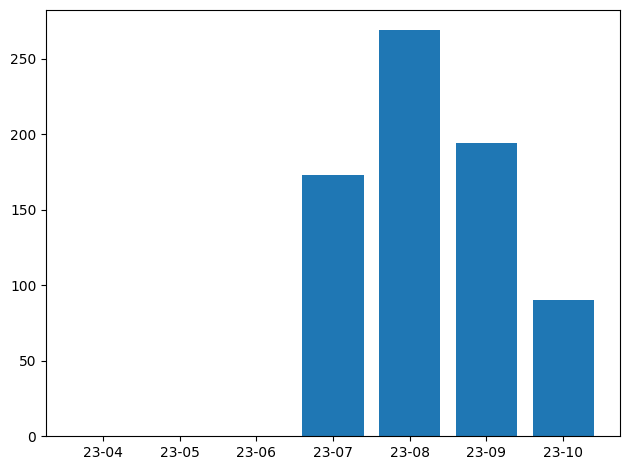

In [28]:
# Display pumps in last 6 months
df = result_df
df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
print(df.tail(12))

fig, ax = plt.subplots()
ax.bar(df['legend'], df['pumps'])

plt.tight_layout() 
plt.show()
# 42 56 41 18